# LSTM

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

data = pd.read_csv('cleaned.csv')

# Convert text column to string type
data['text'] = data['text'].astype(str)
data.rating = data.rating.replace(4,1)

In [2]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

#tok = Tokenizer(num_words=5000, oov_token="<OOV>")
NB_WORDS = 20000
tok = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

tok.fit_on_texts(train_data.text)

train_sequences = tok.texts_to_sequences(train_data['text'])
test_sequences = tok.texts_to_sequences(test_data['text'])

max_length = 100
#pad or truncate
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


vocab_size = len(tok.word_index) + 1

'''lstm_model = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])
'''

from tensorflow.keras.layers import Dropout

lstm_model = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
    Dropout(0.5),
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           515776    
                                                                 
 lstm (LSTM)                 (None, 100, 64)           24832     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [3]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(train_padded, train_data['rating'], 
                         epochs=10, batch_size=32, 
                         validation_data=(test_padded, test_data['rating']))


#from sklearn.utils.class_weight import compute_class_weight
# Compute class weights
#class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=train_data['rating'])

# Fit the model with class weights
'''lstm_history = lstm_model.fit(train_padded, train_data['rating'], 
                              epochs=10, batch_size=32, 
                              validation_data=(test_padded, test_data['rating']),
                              class_weight={0: class_weights[0], 1: class_weights[1]})
                              '''

Epoch 1/10
250/250 [==============================] - 47s 171ms/step - loss: 0.6939 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4835
Epoch 2/10
250/250 [==============================] - 45s 178ms/step - loss: 0.6935 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 3/10
250/250 [==============================] - 53s 213ms/step - loss: 0.6938 - accuracy: 0.4989 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 4/10
250/250 [==============================] - 52s 209ms/step - loss: 0.6936 - accuracy: 0.4997 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 5/10
250/250 [==============================] - 52s 210ms/step - loss: 0.6935 - accuracy: 0.4927 - val_loss: 0.6927 - val_accuracy: 0.5165
Epoch 6/10
250/250 [==============================] - 52s 209ms/step - loss: 0.6934 - accuracy: 0.5021 - val_loss: 0.6944 - val_accuracy: 0.4835
Epoch 7/10
250/250 [==============================] - 54s 217ms/step - loss: 0.6934 - accuracy: 0.4983 - val_loss: 0.6928 - val_ac

"lstm_history = lstm_model.fit(train_padded, train_data['rating'], \n                              epochs=10, batch_size=32, \n                              validation_data=(test_padded, test_data['rating']),\n                              class_weight={0: class_weights[0], 1: class_weights[1]})\n                              "

In [71]:
from sklearn.metrics import classification_report

# Make predictions on test data
y_pred_prob = lstm_model.predict(test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report
report = classification_report(test_data['rating'], y_pred)

print(report)



63/63 [==============================] - 3s 42ms/step
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       967
           1       0.00      0.00      0.00      1033

    accuracy                           0.48      2000
   macro avg       0.24      0.50      0.33      2000
weighted avg       0.23      0.48      0.32      2000



C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
import matplotlib.pyplot as plt
def plot_hist(history, title):
    """
    Vars:
    - history:representing the training history of a model.
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
    
    ax1.plot(history.history['accuracy'], c= 'b')
    ax1.plot(history.history['val_accuracy'], c='r')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    ax2.plot(history.history['loss'], c='m')
    ax2.plot(history.history['val_loss'], c='c')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')
     # Add a title to the entire image
    fig.suptitle(title, fontsize=14)
    plt.show()

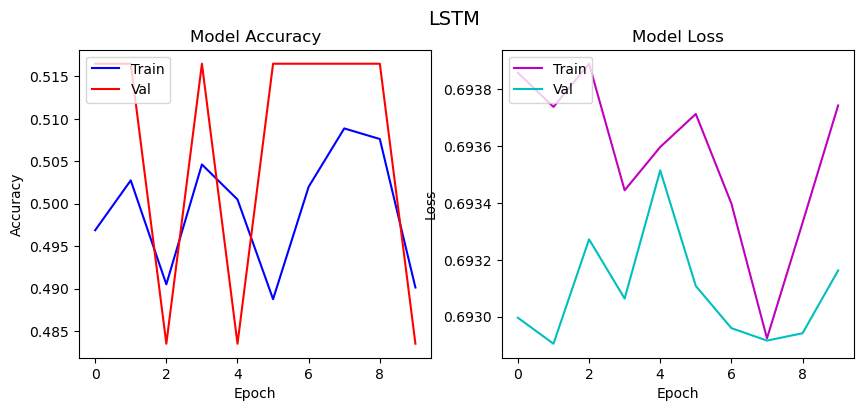

In [74]:
plot_hist(lstm_history,'LSTM')

In [76]:
test_loss, test_acc = lstm_model.evaluate(test_padded, test_data['rating'])

63/63 [==============================] - 2s 31ms/step - loss: 0.6932 - accuracy: 0.4835
